In [1]:
import pandas as pd
import os
import glob
import CBE_utils as CBE
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import importlib
importlib.reload(CBE)

<module 'CBE_utils' from '/home/schmied.christopher/FMP_Docs/Projects/eu_os_ecbl_qc/notebooks/CBE_utils.py'>

In [3]:
input_path = "/media/schmied.christopher/T7 Shield/Datasets/ECBL/processed/"
output_path = "/home/schmied.christopher/FMP_Docs/Projects/eu_os_ecbl_qc/results/"

annotation_dir = "/home/schmied.christopher/FMP_Docs/Projects/eu_os_ecbl_qc/annotation/"

# For test
input_path = "/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis_revision/test_output/"
output_path = "/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis_revision/test_results/"

annotation_dir = "/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis_revision/test_annotation/"

In [4]:
# get folder list 
# load for each site the normalized files
# reduce the features selecting the correct feature list
folders = [name for name in os.listdir(input_path) if os.path.isdir(os.path.join(input_path, name))]

In [5]:
pattern = "[A-Z]*_R[1-4]_mad_robustize_reduced-corr.csv"

FMP_Data = []
IMTM_Data = []
MEDINA_Data = []
USC_Data = []

for folder in folders:

    site_specific_path = os.path.join(input_path, folder)

    # load normalized data
    file_list = glob.glob(site_specific_path + os.sep + '*' + os.sep + pattern, recursive=True)

    for file in file_list:

        filename = os.path.basename(file)
    
        try:
        
            Data_Temp = pd.read_csv(file)
            row_count = Data_Temp.shape[0]
        
            print(f"File: {filename} has {row_count} rows")
        
            if folder == 'FMP':
                
                FMP_Data.append(Data_Temp)

            elif folder == 'IMTM':

                IMTM_Data.append(Data_Temp)

            elif folder == 'MEDINA':

                MEDINA_Data.append(Data_Temp)

            elif folder == 'USC':

                USC_Data.append(Data_Temp)
            
        except Exception as e:
        
            print(f"Error reading file {filename}: {e}")


File: C1084_R1_mad_robustize_reduced-corr.csv has 384 rows
File: C1084_R2_mad_robustize_reduced-corr.csv has 384 rows
File: C1084_R3_mad_robustize_reduced-corr.csv has 312 rows
File: C1084_R4_mad_robustize_reduced-corr.csv has 384 rows
File: C1085_R1_mad_robustize_reduced-corr.csv has 384 rows
File: C1085_R2_mad_robustize_reduced-corr.csv has 380 rows
File: C1085_R3_mad_robustize_reduced-corr.csv has 384 rows
File: C1085_R4_mad_robustize_reduced-corr.csv has 384 rows
File: C1086_R1_mad_robustize_reduced-corr.csv has 384 rows
File: C1086_R2_mad_robustize_reduced-corr.csv has 384 rows
File: C1086_R3_mad_robustize_reduced-corr.csv has 384 rows
File: C1086_R4_mad_robustize_reduced-corr.csv has 384 rows
File: C1087_R1_mad_robustize_reduced-corr.csv has 384 rows
File: C1087_R2_mad_robustize_reduced-corr.csv has 384 rows
File: C1087_R3_mad_robustize_reduced-corr.csv has 384 rows
File: C1087_R4_mad_robustize_reduced-corr.csv has 384 rows
File: C1088_R1_mad_robustize_reduced-corr.csv has 384 ro

In [6]:
### concat all files together
FMP_Data_aggregated = pd.concat(FMP_Data)
FMP_Data_aggregated = FMP_Data_aggregated.reset_index(drop = True)
print("Aggregated Data has shape ", FMP_Data_aggregated.shape)

Aggregated Data has shape  (110623, 364)


In [7]:
IMTM_Data_aggregated = pd.concat(IMTM_Data)
IMTM_Data_aggregated = IMTM_Data_aggregated.reset_index(drop = True)
print("Aggregated Data has shape ", IMTM_Data_aggregated.shape)

Aggregated Data has shape  (123232, 436)


In [8]:
MEDINA_Data_aggregated = pd.concat(MEDINA_Data)
MEDINA_Data_aggregated = MEDINA_Data_aggregated.reset_index(drop = True)
print("Aggregated Data has shape ", MEDINA_Data_aggregated.shape)

Aggregated Data has shape  (112065, 616)


In [9]:
USC_Data_aggregated = pd.concat(USC_Data)
USC_Data_aggregated = USC_Data_aggregated.reset_index(drop = True)
print("Aggregated Data has shape ", USC_Data_aggregated.shape)

Aggregated Data has shape  (111938, 641)



# Comparison over plates

In [10]:
# TODO: Correlation of pos. & neg. controls over time
# TODO: Compute consensus per normalized plate for pos. controls
# TODO: Implement consensus of first plates of specific source
# TODO: Then with an external control from the bioactives
# TODO: Create reference point for pos. controls and compare plates to this

In [13]:
def interplate_qc(Data_aggregated, source):

    # Gets the feature and metadata columns
    features_columns = CBE.get_feature_vector(Data_aggregated)
    metadata_columns = set(Data_aggregated) - set(features_columns)

    columns_to_drop = [
        'Metadata_imaging_date',
        'Metadata_staining_date',
        'Metadata_imaging_time',
        'Metadata_Plate',
        'Metadata_plate_name',
        'Metadata_replicate_number',
        'Metadata_source',
        'Metadata_user',
        'Metadata_RoughID']

    # Compute the mean profiles for pos. controls put into new table
    source_pos_ctrl = Data_aggregated[Data_aggregated['Metadata_RoughID'].isin(['Tetrandrine','Nocodazole'])]

    # Here the mean is used as this makes most sense for the QC
    source_pos_ctrl_mean = source_pos_ctrl.groupby(['Metadata_imaging_date',
                                                    'Metadata_staining_date',
                                                    'Metadata_imaging_time',
                                                    'Metadata_Plate',
                                                    'Metadata_plate_map_name',
                                                    'Metadata_plate_name',
                                                    'Metadata_replicate_number',
                                                    'Metadata_source',
                                                    'Metadata_user',
                                                    'Metadata_RoughID'],dropna=False)[features_columns].mean().reset_index().copy()
    
    batch_list = source_pos_ctrl_mean["Metadata_staining_date"].unique()

    for batch in batch_list:

        print(batch)

        batch_source_Data_aggregated = source_pos_ctrl_mean.loc[source_pos_ctrl_mean["Metadata_staining_date"] == batch].reset_index()

        ctrl_list = ('Nocodazole', 'Tetrandrine')

        for ctrl in ctrl_list:

            batch_source_Data_aggregated_ctrl = batch_source_Data_aggregated.loc[batch_source_Data_aggregated['Metadata_RoughID'] == ctrl].reset_index()

            batch_source_Data_aggregated_ctrl_2 = batch_source_Data_aggregated_ctrl.drop(columns_to_drop, axis=1)
            correlation_ctrl = batch_source_Data_aggregated_ctrl_2.set_index('Metadata_plate_map_name')
            correlation_ctrl_matrix = correlation_ctrl.T.corr()

            # Plot the correlation matrix using a heatmap
            plt.figure(figsize=(10, 8))
            sns.heatmap(correlation_ctrl_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
            plt.title(source + " " + str(batch) + " " + ctrl + " correlation", loc = 'left',fontsize= 16)
            plt.xlabel('Plate Map Name')
            plt.ylabel('Plate Map Name')

            # Cell Number output for FMP
            figure_path = os.path.join(output_path + os.sep + source + os.sep + 'intra_batch')  

            try:
                os.makedirs(figure_path, exist_ok=True)
            
            except OSError as error:
            
                print("Error: directory cannot be created") 

            plt.savefig(figure_path + os.sep + str(batch) + '_' + source + '_' + ctrl + '_IntraBatchCorr.pdf', format='pdf', bbox_inches = "tight")
            plt.close()

In [14]:
interplate_qc(IMTM_Data_aggregated, 'IMTM')

/tmp/ipykernel_35944/595732031.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  'Metadata_RoughID'],dropna=False)[features_columns].mean().reset_index().copy()
/tmp/ipykernel_35944/595732031.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  'Metadata_RoughID'],dropna=False)[features_columns].mean().reset_index().copy()
/tmp/ipykernel_35944/595732031.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all 

2024-05-29
2024-05-31
2024-06-05
2024-06-07
2024-06-12
2024-06-19
2024-06-21
2024-06-26
2024-06-30
2024-07-03
2024-07-10
2024-07-11
2024-07-12
2024-07-17
2024-07-24
2024-07-19
2024-07-25
2024-08-14
2024-08-15
2024-08-16
2024-08-22
2024-08-23
2024-09-04
2024-09-06
2024-10-25
2024-11-01
2024-11-06
2024-11-08
2024-12-04
2024-12-06
2024-11-29
2024-12-11
2025-01-08
2025-01-10
2025-01-14
2025-01-17
2025-04-11
2025-04-15
2025-04-18
2025-04-23
2025-04-17
2025-05-14
2025-05-16
2025-05-21
2025-05-22
2025-05-28
2025-07-24
2025-10-22
2025-11-18
2025-12-10
2025-12-12


In [15]:
interplate_qc(FMP_Data_aggregated, 'FMP')

/tmp/ipykernel_35944/595732031.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  'Metadata_RoughID'],dropna=False)[features_columns].mean().reset_index().copy()
/tmp/ipykernel_35944/595732031.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  'Metadata_RoughID'],dropna=False)[features_columns].mean().reset_index().copy()
/tmp/ipykernel_35944/595732031.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all 

2024-09-04
2024-09-06
2024-09-11
2024-10-02
2024-10-18
2024-11-06
2024-11-13
2024-11-29
2024-12-10
2025-02-26
2025-02-28
2025-07-16
2025-07-18
2025-07-23
2025-07-25
2024-06-21
2025-08-27
2025-08-29
2025-08-13
2025-08-15


In [16]:
interplate_qc(USC_Data_aggregated, 'USC')

/tmp/ipykernel_35944/595732031.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  'Metadata_RoughID'],dropna=False)[features_columns].mean().reset_index().copy()
/tmp/ipykernel_35944/595732031.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  'Metadata_RoughID'],dropna=False)[features_columns].mean().reset_index().copy()
/tmp/ipykernel_35944/595732031.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all 

2024-06-13
2024-06-14
2024-06-19
2024-06-21
2024-06-26
2024-06-27
2024-06-28
2024-07-03
2024-07-04
2024-07-10
2024-07-11
2024-07-18
2024-07-19
2024-07-24
2024-07-26
2024-07-30
2024-09-12
2024-09-18
2024-09-20
2024-09-26
2024-09-27
2024-10-02
2024-10-03
2024-10-04
2024-10-09
2024-10-11
2024-10-16
2024-10-18
2024-10-23
2024-10-24
2024-10-25
2024-10-10
2025-03-06
2025-04-25
2025-04-30
2025-05-07
2025-05-08
2025-05-09
2025-05-28
2025-06-04
2025-10-17


In [17]:
interplate_qc(MEDINA_Data_aggregated, 'MEDINA')

/tmp/ipykernel_35944/595732031.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  'Metadata_RoughID'],dropna=False)[features_columns].mean().reset_index().copy()
/tmp/ipykernel_35944/595732031.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  'Metadata_RoughID'],dropna=False)[features_columns].mean().reset_index().copy()
/tmp/ipykernel_35944/595732031.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all 

2024-07-17
2024-07-18
2024-07-24
2024-09-11
2024-09-12
2024-09-18
2024-09-19
2024-09-20
2024-09-27
2024-10-23
2024-10-24
2024-10-25
2024-10-30
2024-10-31
2024-11-06
2024-11-07
2024-11-08
2024-11-21
2024-11-22
2024-12-12
2024-12-18
2025-01-22
2025-01-23
2025-02-05
2025-02-12
2025-02-13
2025-04-23
2025-04-24
2025-05-07
2025-05-08
2025-05-16
2025-07-15


# Compute correlation matrix over different batches

In [ ]:
def interbatch_qc(Data_aggregated, source):

    features_columns = CBE.get_feature_vector(Data_aggregated)

    columns_to_drop = [
    'Metadata_source',
    'Metadata_RoughID']

    # Compute the mean profiles for pos. controls put into new table
    source_pos_ctrl = Data_aggregated[Data_aggregated['Metadata_RoughID'].isin(['Tetrandrine','Nocodazole'])]

    # Here the mean is used as it makes most sense for a qc 
    source_pos_ctrl_mean = source_pos_ctrl.groupby(['Metadata_staining_date',
                                                    'Metadata_source',
                                                    'Metadata_RoughID'])[features_columns].mean().reset_index()

    ctrl_list = ('Nocodazole', 'Tetrandrine')

    for ctrl in ctrl_list:
        
        source_Data_aggregated_ctrl = source_pos_ctrl_mean.loc[source_pos_ctrl_mean['Metadata_RoughID'] == ctrl].reset_index()

        source_Data_aggregated_ctrl_2 = source_Data_aggregated_ctrl.drop(columns_to_drop, axis=1)
        correlation_ctrl = source_Data_aggregated_ctrl_2.set_index('Metadata_staining_date')
        correlation_ctrl_matrix = correlation_ctrl.T.corr()

        # Plot the correlation matrix using a heatmap
        plt.figure(figsize=(14, 12))
        sns.set(font_scale=0.4)
        sns.heatmap(correlation_ctrl_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        #plt.title(source + " " + str(batch) + " " + ctrl + " correlation", loc = 'left',fontsize= 16)
        plt.xlabel('Imaging date')
        plt.ylabel('Imaging date')

        # Cell Number output for FMP
        figure_path = os.path.join(output_path + os.sep + source)  

        

        try:
            os.makedirs(figure_path, exist_ok=True)
            
        except OSError as error:
            
            print("Error: directory cannot be created") 

        plt.savefig(figure_path + os.sep + source + '_' + ctrl + '_InterBatchCorr.pdf', format='pdf', bbox_inches = "tight")


        # Plot the correlation matrix using a heatmap
        plt.figure(figsize=(14, 12))
        sns.set(font_scale=0.4)
        sns.heatmap(correlation_ctrl_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
        plt.xlabel('Imaging date')
        plt.ylabel('Imaging date')

        # Cell Number output for FMP
        figure_path = os.path.join(output_path + os.sep + source) 

        plt.savefig(figure_path + os.sep + source + '_' + ctrl + '_InterBatchCorr_AnnotFalse.pdf', format='pdf', bbox_inches = "tight")



/tmp/ipykernel_35944/1973967135.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  'Metadata_RoughID'])[features_columns].mean().reset_index()
/tmp/ipykernel_35944/1973967135.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  'Metadata_RoughID'])[features_columns].mean().reset_index()
/tmp/ipykernel_35944/1973967135.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=

Error: directory cannot be created


/tmp/ipykernel_35944/1973967135.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  source_Data_aggregated_ctrl = source_pos_ctrl_mean.loc[source_pos_ctrl_mean['Metadata_RoughID'] == ctrl].reset_index()


Error: directory cannot be created


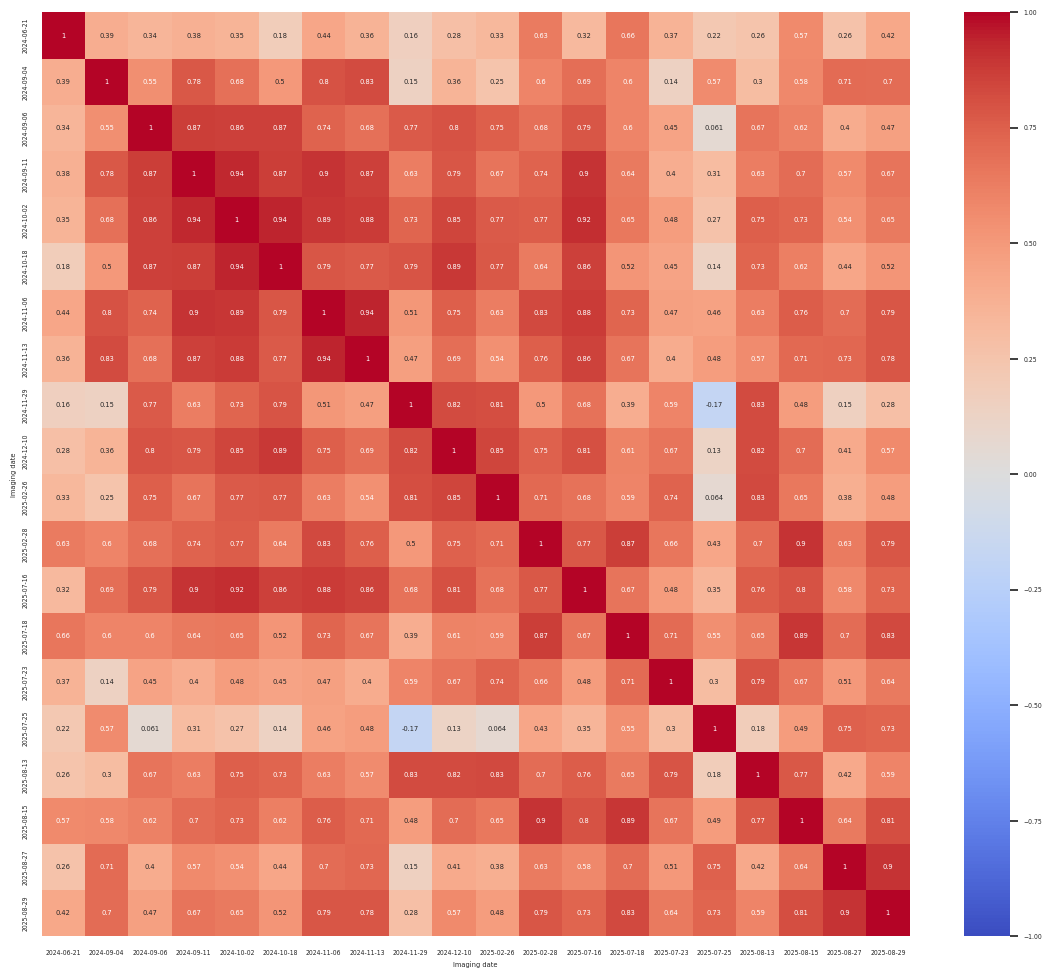

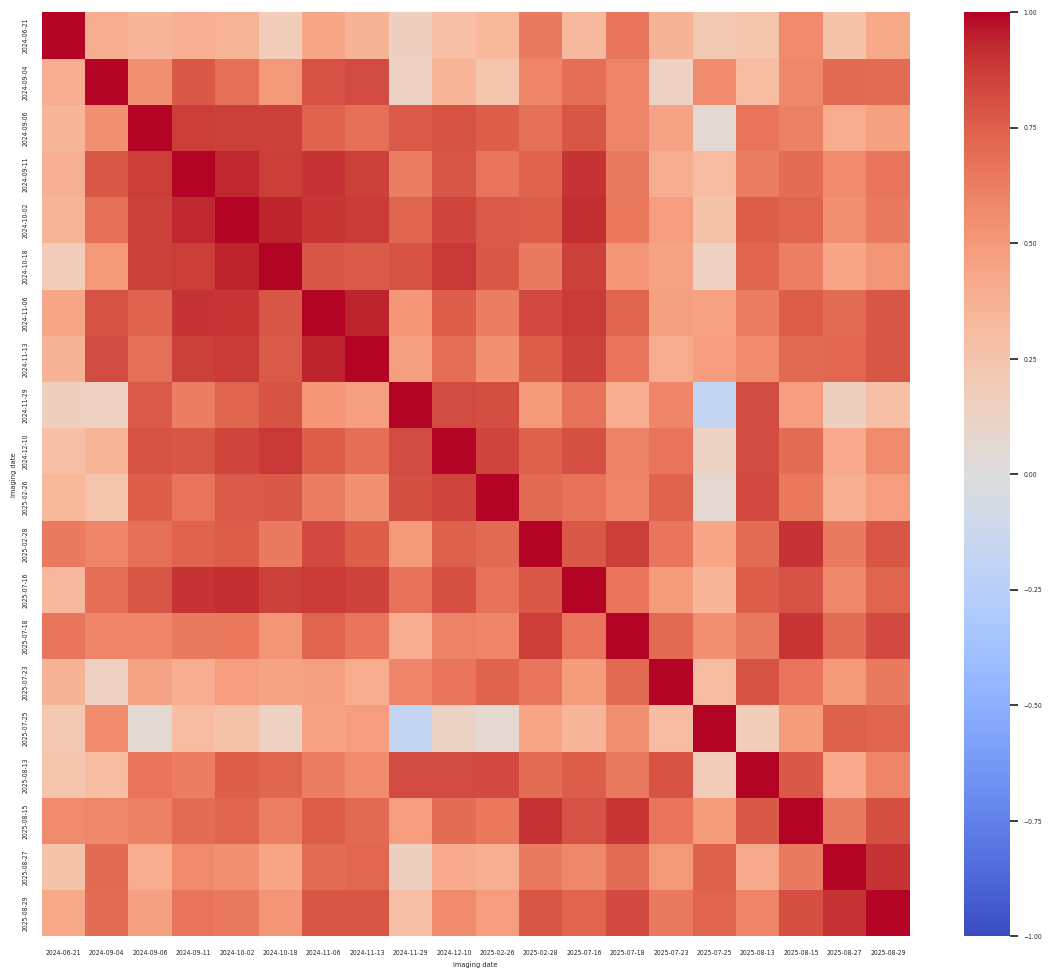

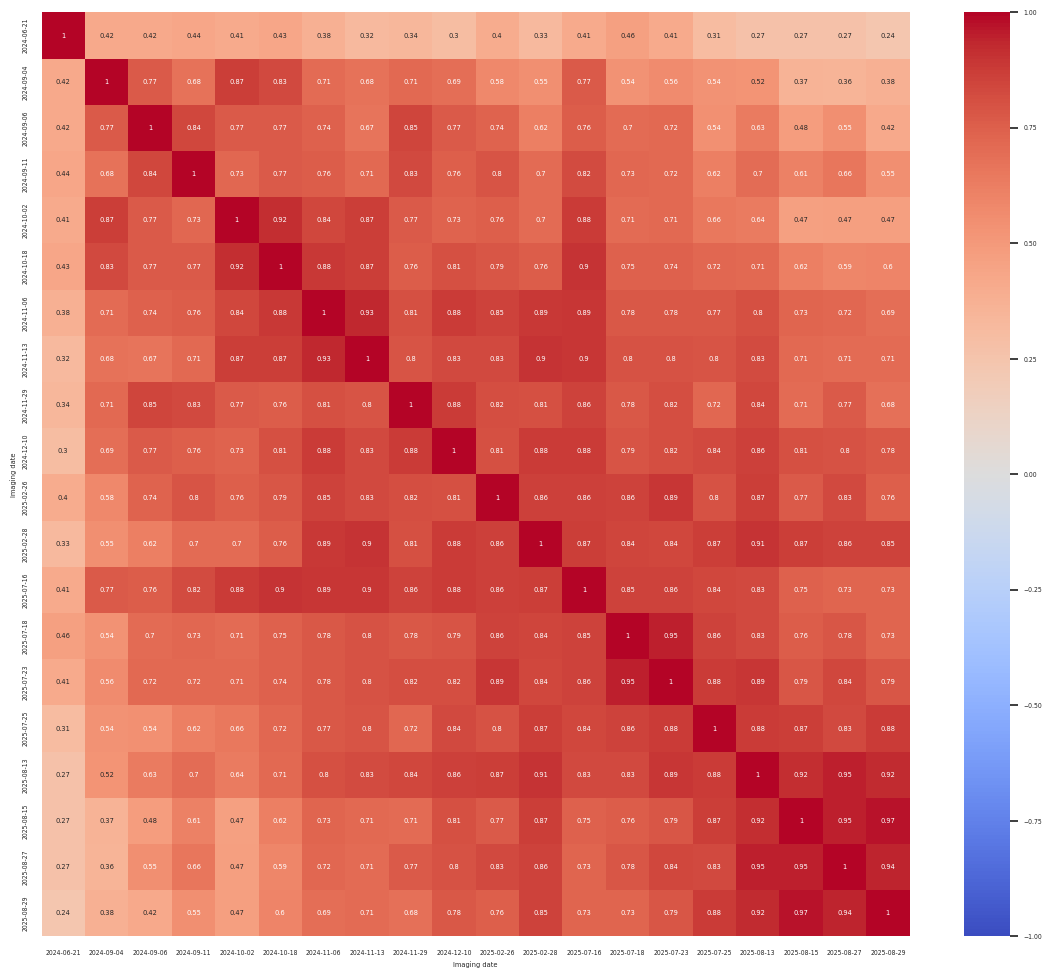

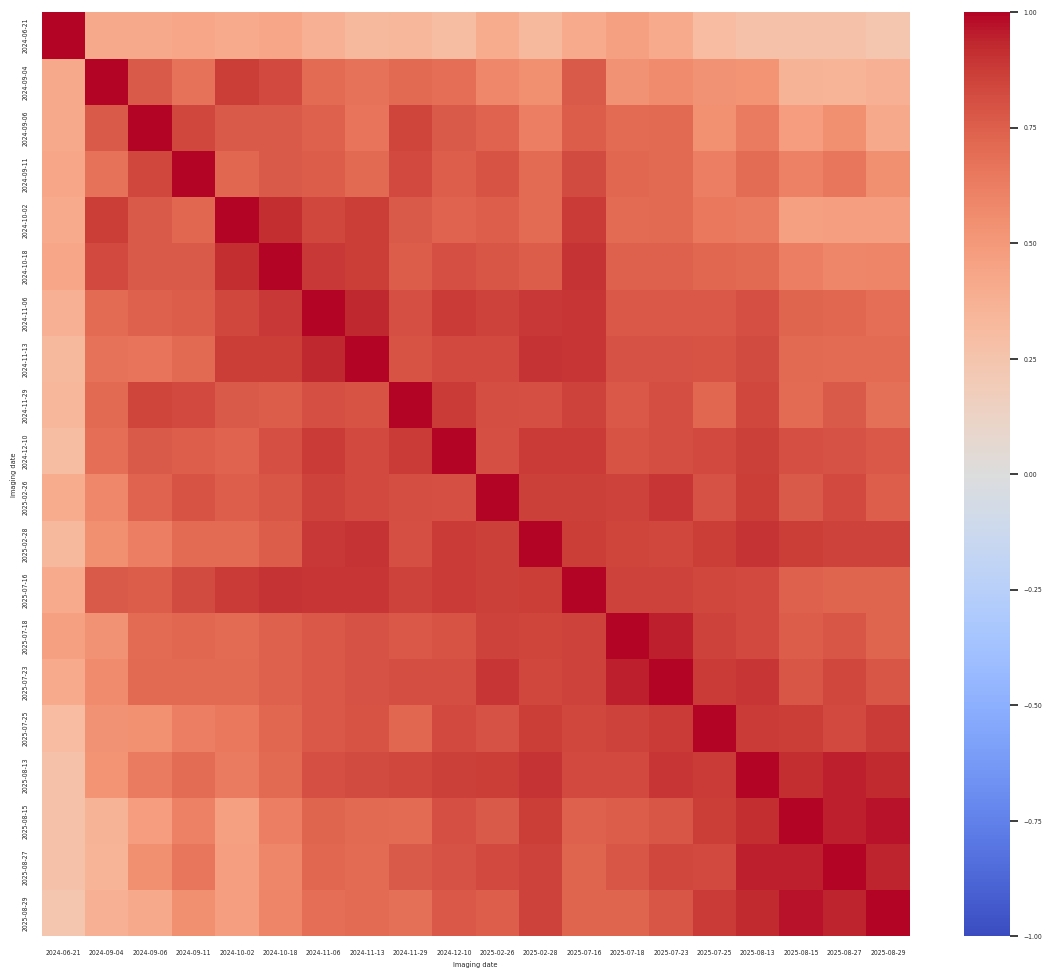

In [19]:
interbatch_qc(FMP_Data_aggregated, 'FMP')

/tmp/ipykernel_35944/1973967135.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  'Metadata_RoughID'])[features_columns].mean().reset_index()
/tmp/ipykernel_35944/1973967135.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  'Metadata_RoughID'])[features_columns].mean().reset_index()
/tmp/ipykernel_35944/1973967135.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=

Error: directory cannot be created


/tmp/ipykernel_35944/1973967135.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  source_Data_aggregated_ctrl = source_pos_ctrl_mean.loc[source_pos_ctrl_mean['Metadata_RoughID'] == ctrl].reset_index()


Error: directory cannot be created


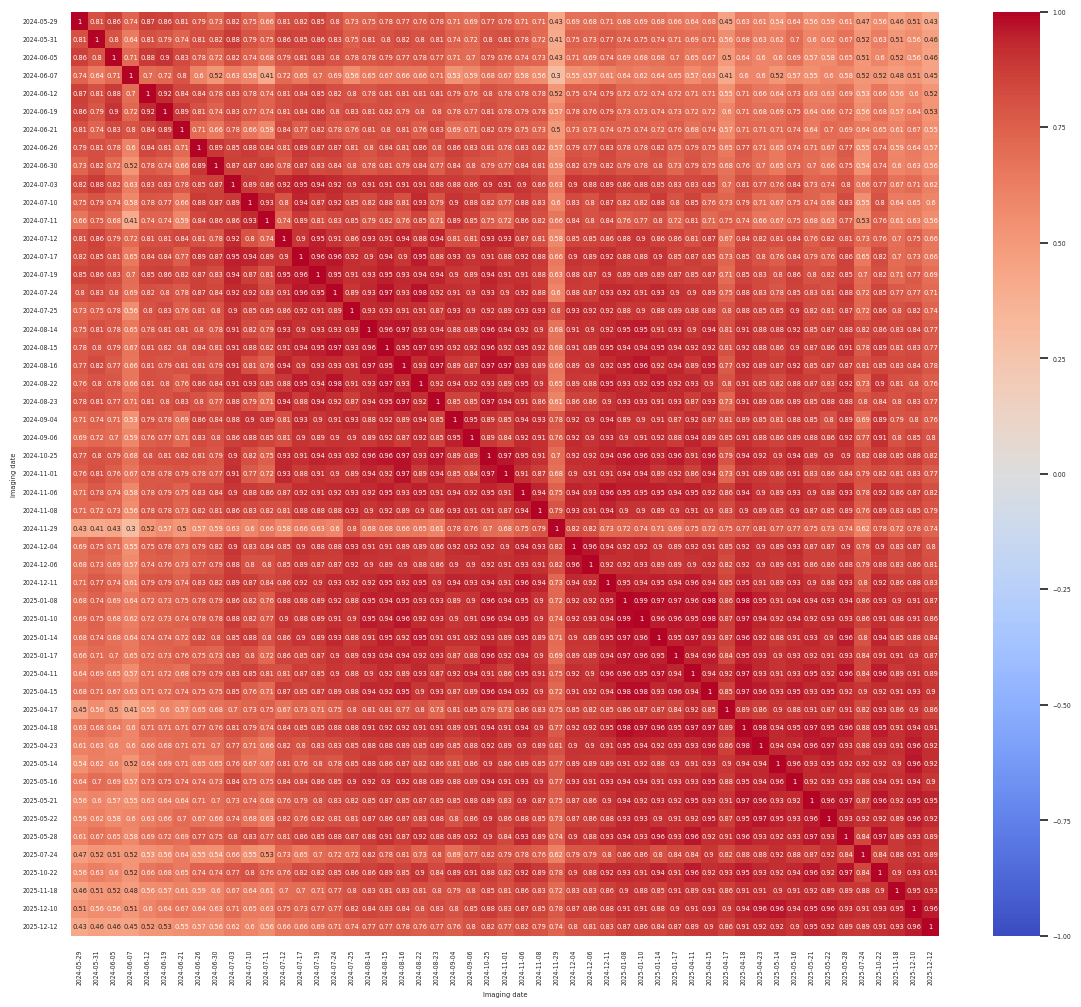

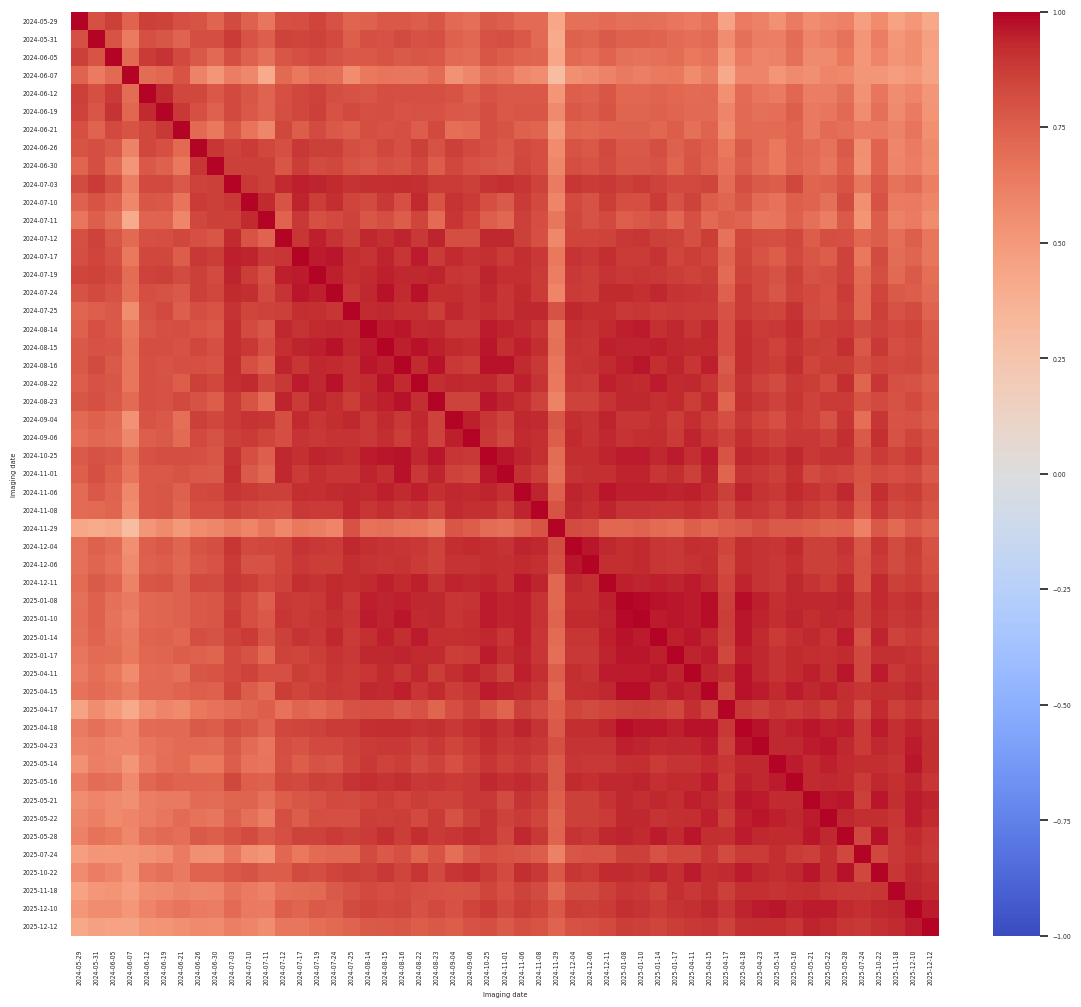

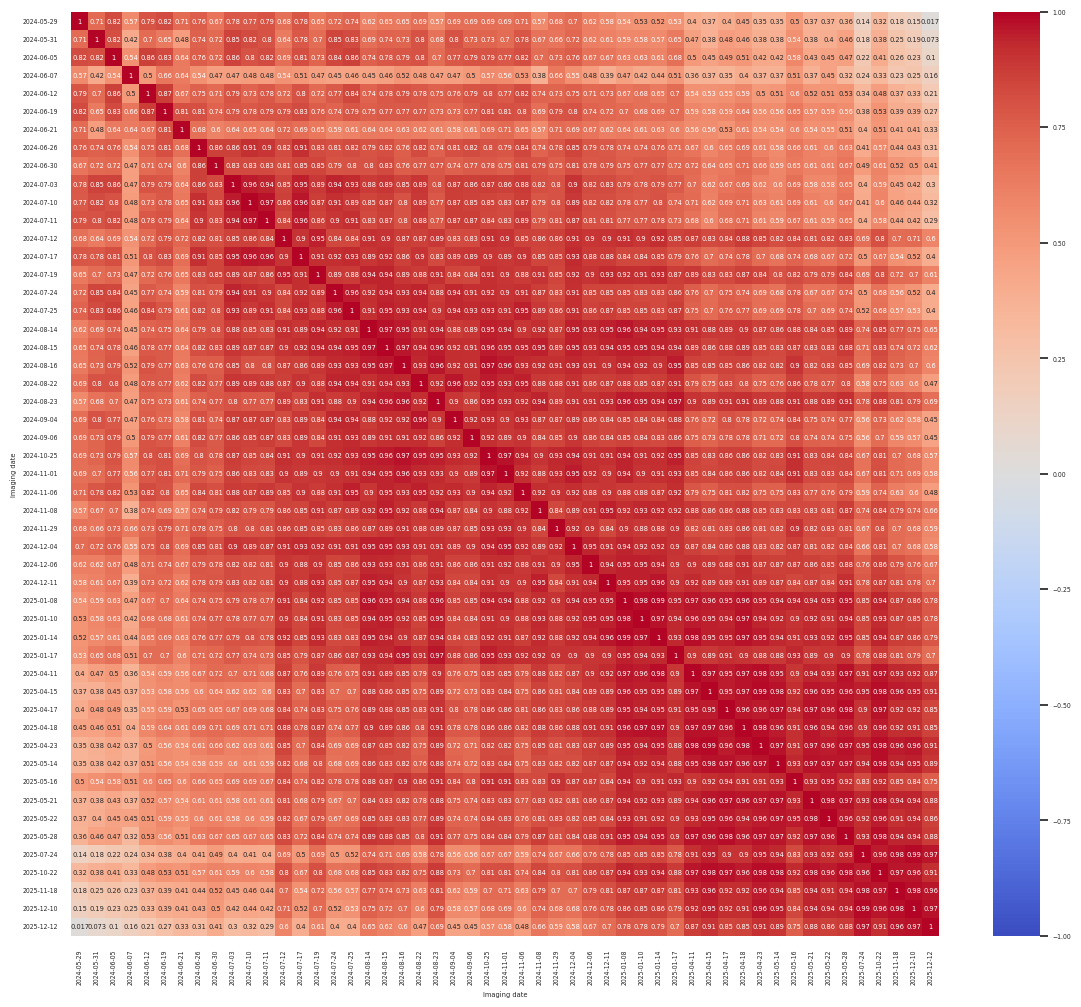

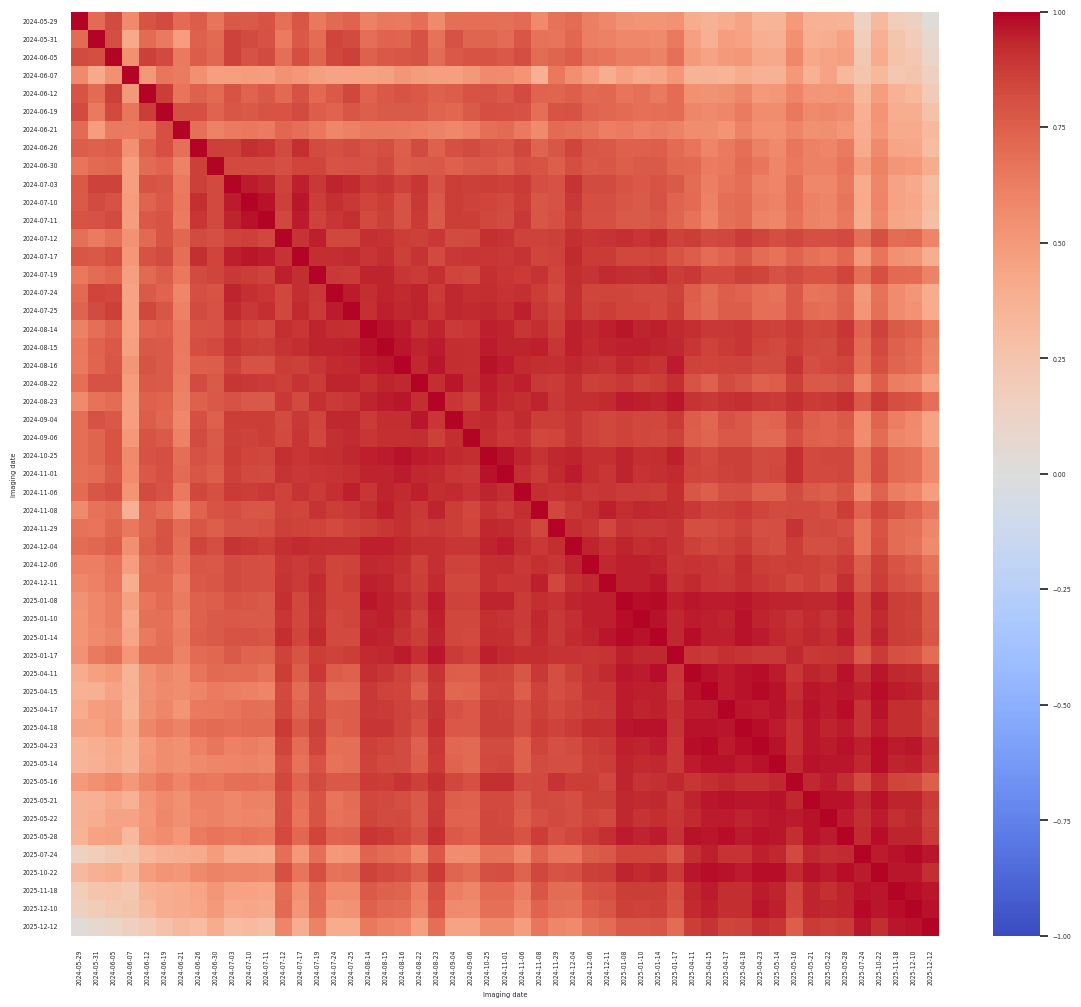

In [20]:
interbatch_qc(IMTM_Data_aggregated, 'IMTM')

/tmp/ipykernel_35944/1973967135.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  'Metadata_RoughID'])[features_columns].mean().reset_index()
/tmp/ipykernel_35944/1973967135.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  'Metadata_RoughID'])[features_columns].mean().reset_index()
/tmp/ipykernel_35944/1973967135.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=

Error: directory cannot be created


/tmp/ipykernel_35944/1973967135.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  source_Data_aggregated_ctrl = source_pos_ctrl_mean.loc[source_pos_ctrl_mean['Metadata_RoughID'] == ctrl].reset_index()


Error: directory cannot be created


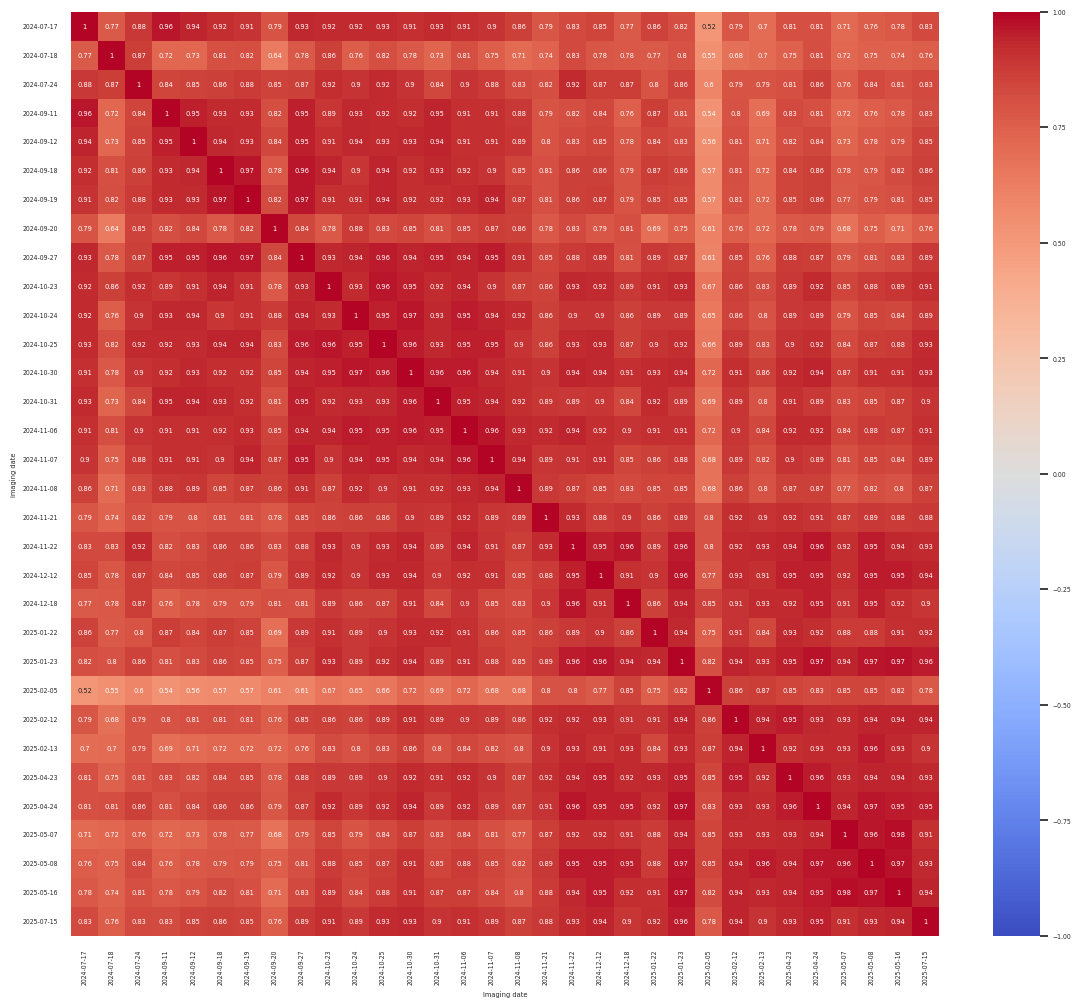

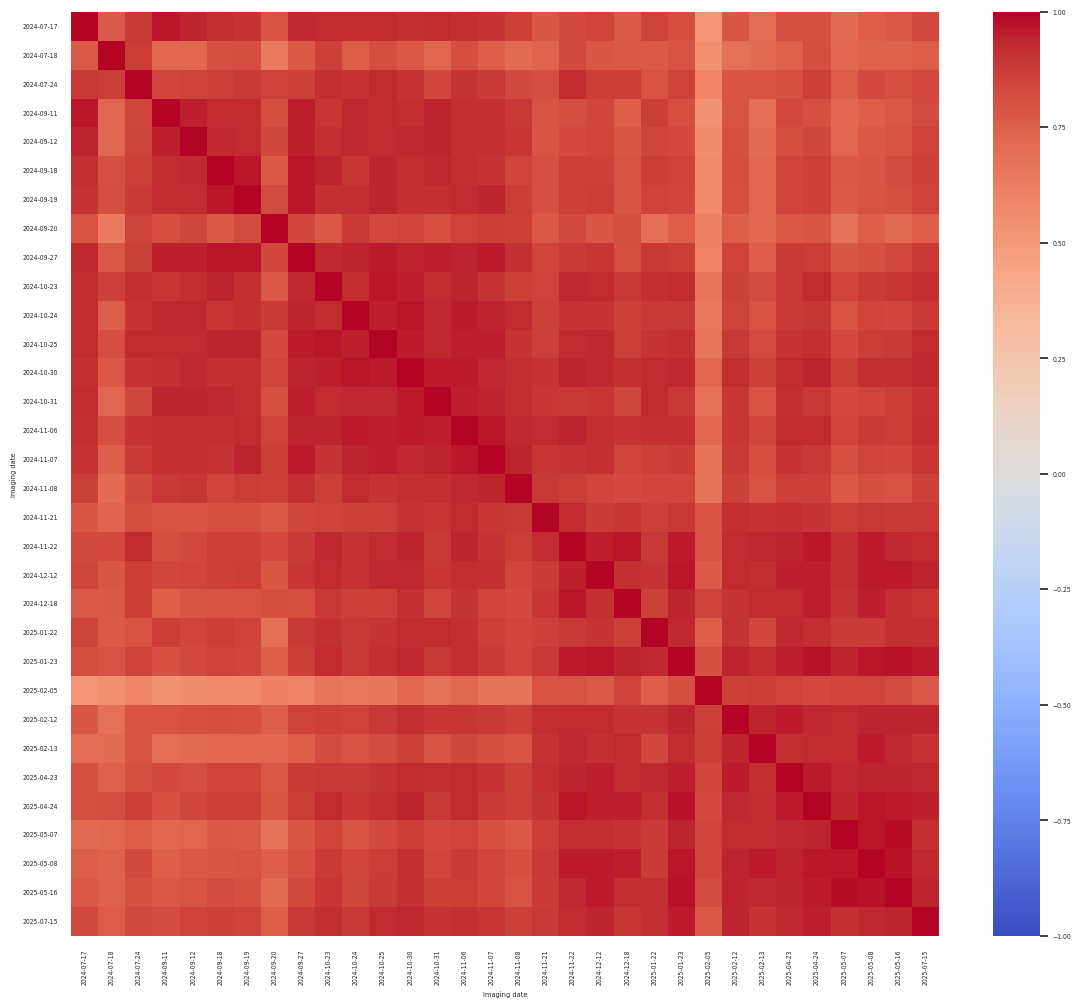

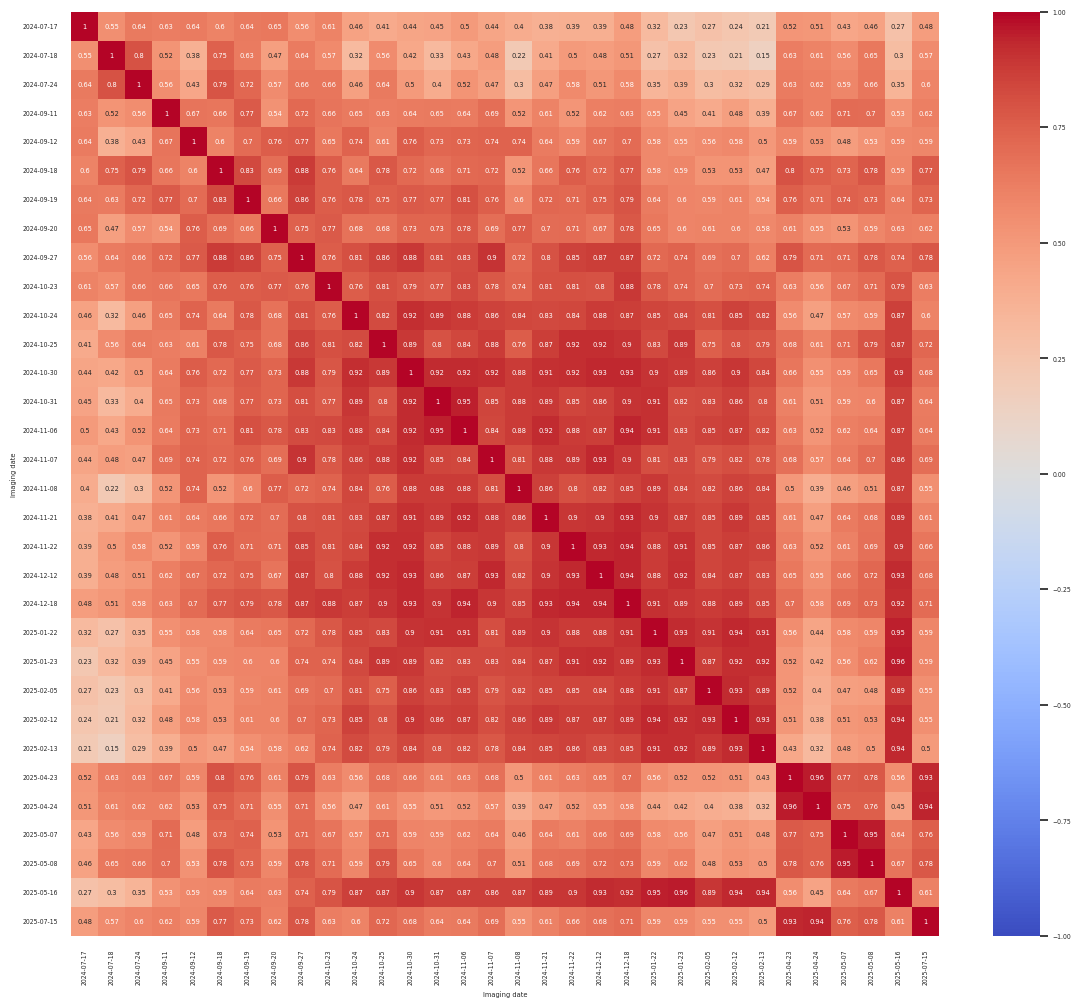

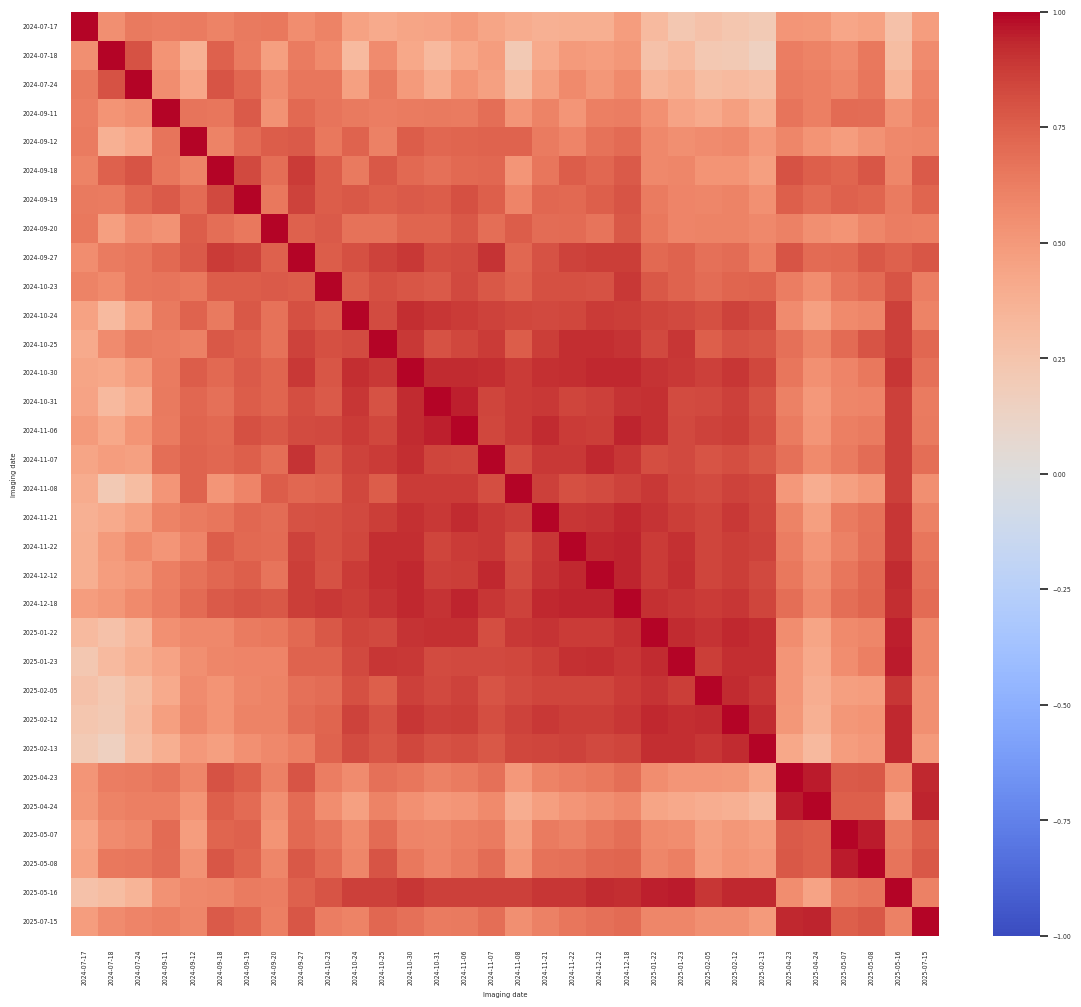

In [21]:
interbatch_qc(MEDINA_Data_aggregated, 'MEDINA')

/tmp/ipykernel_35944/1973967135.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  'Metadata_RoughID'])[features_columns].mean().reset_index()
/tmp/ipykernel_35944/1973967135.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  'Metadata_RoughID'])[features_columns].mean().reset_index()
/tmp/ipykernel_35944/1973967135.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=

Error: directory cannot be created


/tmp/ipykernel_35944/1973967135.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  source_Data_aggregated_ctrl = source_pos_ctrl_mean.loc[source_pos_ctrl_mean['Metadata_RoughID'] == ctrl].reset_index()


Error: directory cannot be created


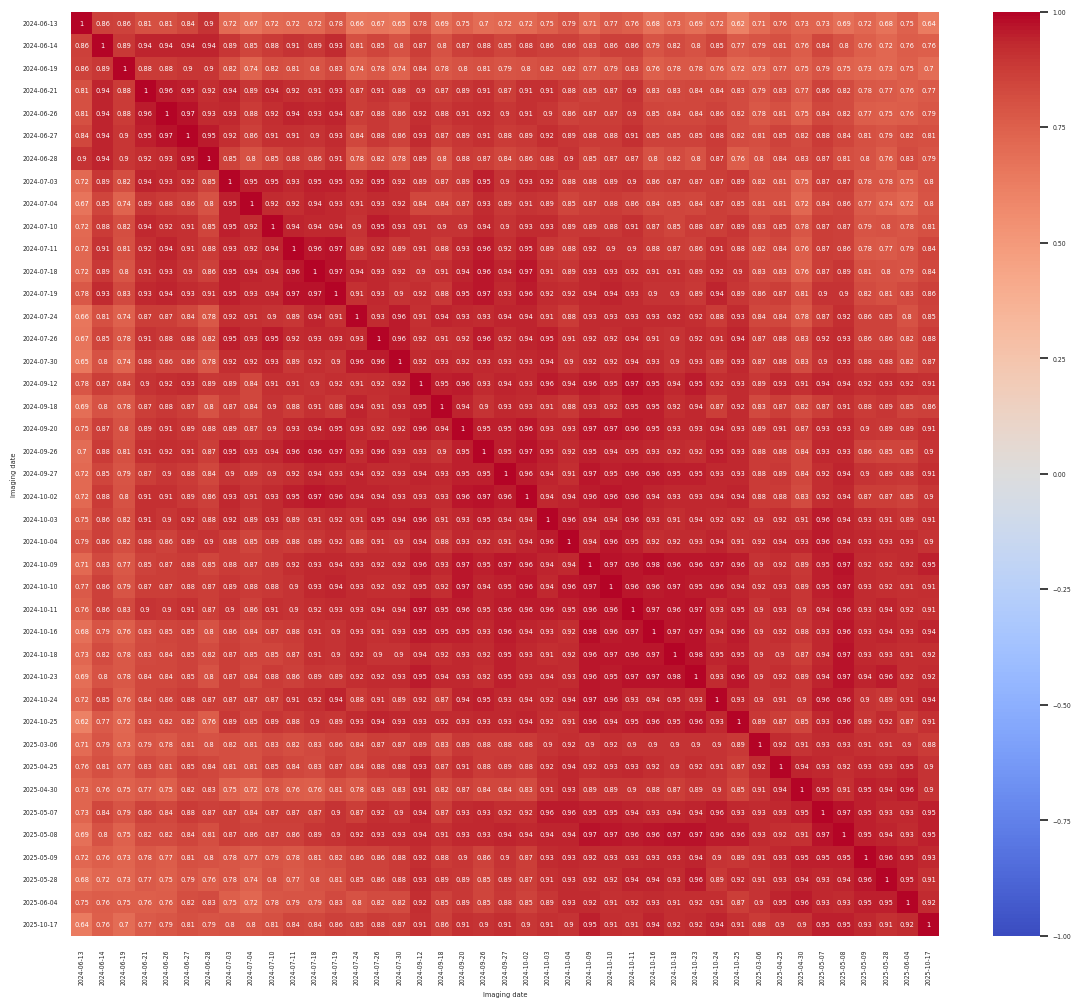

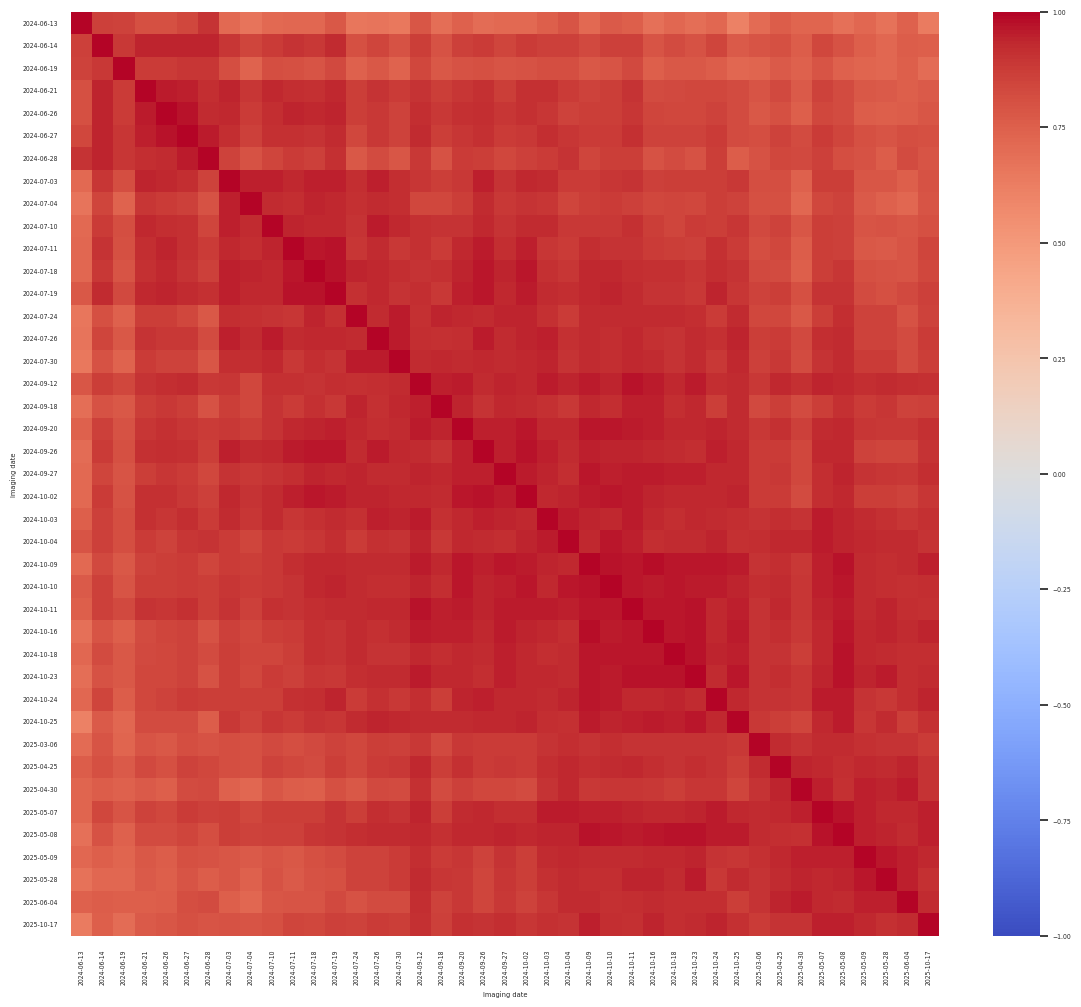

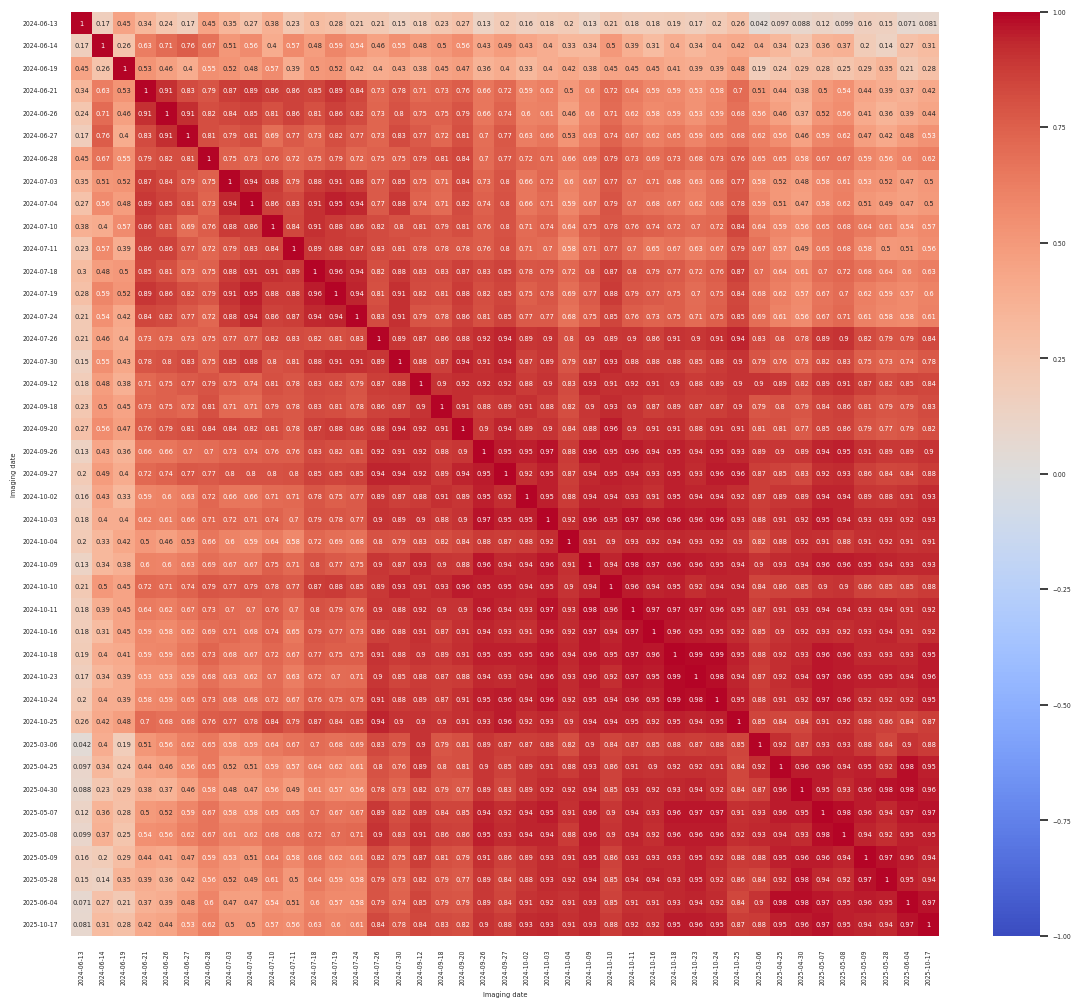

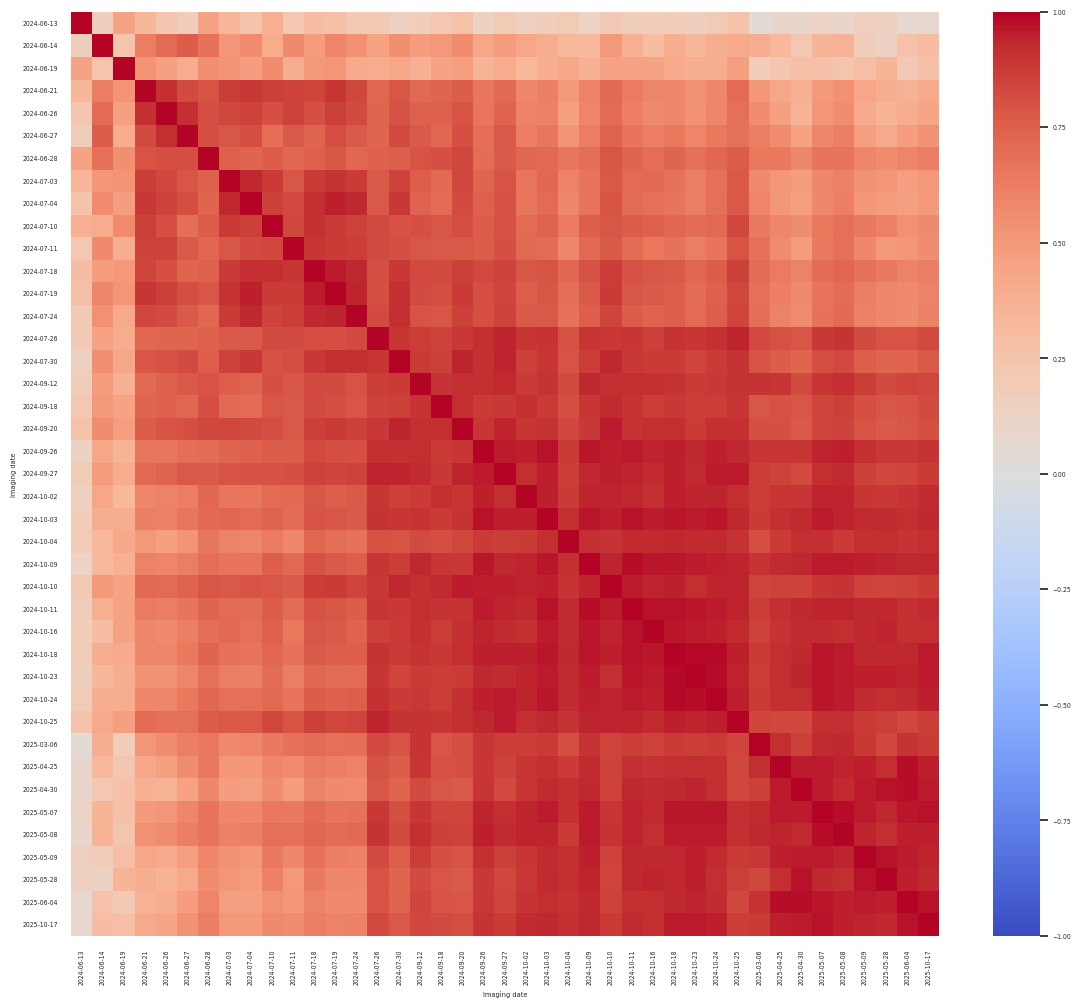

In [22]:
interbatch_qc(USC_Data_aggregated, 'USC')